# STAT 628 Module 1: Body Fat Percentage Predictions
### Group 6

In [1]:
options(warn=-1)
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
$(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

# Introduction and Motivation

The body fat percentage (BFP) of a human is a value that tells you how much of your body weight is made up of fat.

If the body fat percentage is too low, our energy levels and resistance to diseases are lower. However, if the body fat percentage is too high, we may have a higher risk of diabetes and other health problems. In terms of overall health, body fat percentage may be an important number for us.

Unlike height and weight, BFP cannot be measured easily and directly. Therefore, the goal of this project is to develop a simple rule of thumb technique for estimating the body fat percentage using only measurements which can be easily obtained. In addition to being simple, we wish for our estimator to be robust, accurate, and precise. This means it should give reasonably accurate predictions for most people, and its predictions for outliers should not be extremely unreasonable.

# Data Description

The dataset contains 252 observations of 16 features, such as:

* $BODYFAT$ (%)
* $DENSITY$ (gm/cm$^{3}$)
* $AGE$ (years)
* $WEIGHT$ (lbs)

Among these features, $DENSITY$ is measured accurately from underwater weighing and $BODYFAT$ is obtained by Siri's equation, which is a linear relation between body fat percentage and density:

$B = \frac{495}{D} - 450$.

(**Note**: $B$ is the percentage of body fat and $D$ is body density.)

# Data cleaning

Before doing staistical analysis, we first look at the summary of data to see if there are strange points.

In [2]:
# Packages
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
suppressPackageStartupMessages(library(glmnet))
library(leaps)
suppressPackageStartupMessages(library(car))
set.seed(628)

# Open dataset
dat <- suppressMessages(read_csv("data/BodyFat.csv"))

After looking at the summary of raw data, we found several suspicious points

1. 182th: the bodyfat is zero
2. 42th: height is only 29.5 which is not reasonable for those males
3. 39th: weight is 363.1 which is extremely heavy
4. 79th: age is 81 which is pretty old

In order to evaluate if those points are wrong measurements, we need to look at their whole records, we will show this in the below outlier detection part.

Linear regression is sensitive to outliers, so we detect outliers by two different ways. First, we use Siri's equation since we know there should be a linear relation between $BODYFAT$ and $DENSITY$.

In [3]:
# Root MSE calculator
root.mse <- function(y, yhat) {
  return(sqrt(mean((y - yhat) ^ 2)))
}

# Siri's equation for calculating body fat percentage from density
siri <- function(density) {
  return(495 / density - 450)
}

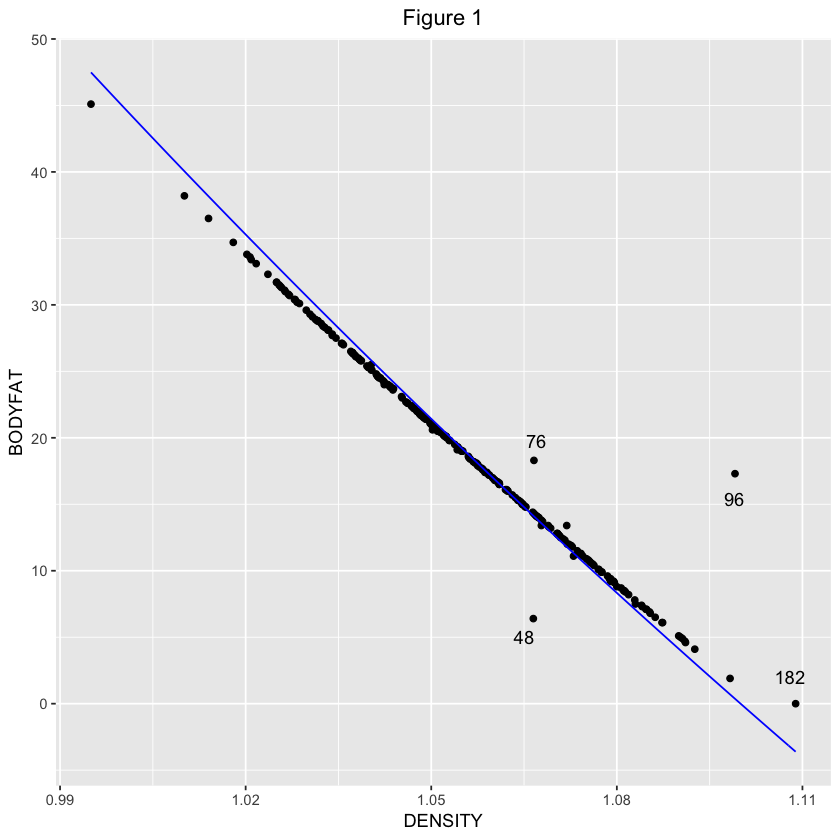

In [4]:
# Examine the difference between BODYFAT and values calculated with Siri's eq.
fig1 <- ggplot(dat, aes(DENSITY, BODYFAT)) + geom_point() +
  stat_function(fun = siri, n = 101, color = "blue") +
  annotate("text", 1.065, 5, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 5 & dat$BODYFAT < 10))) +
  annotate("text", 1.099, 15.4, label = as.numeric(which(
    dat$DENSITY < 1.11 & dat$DENSITY > 1.09 & dat$BODYFAT > 15 & dat$BODYFAT < 20))) +
  annotate("text", 1.108, 2, label = as.numeric(which(
    dat$DENSITY > 1.1 & dat$BODYFAT < 5))) +
  annotate("text", 1.067, 19.8, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 18 & dat$BODYFAT < 20))) +
  labs(title = "Figure 1") + theme(plot.title = element_text(hjust = 0.5))
plot(fig1)

From Figure 1, three records 48, 96, 182，76 seem abnormal.

In [5]:
# Look at abnomal points to see if they should be deleted
dat[c(48, 76, 96, 182),]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


* **48**: The BODYFAT calculated by DENSITY is about 14.1%, but 6.4% seems to be a possible value which measn there may be some measurement error in density,so we just keep this bodyfat value. Then we build a linear regression model to detect whether this is an outlier by Cook's distance.
* **76**: The BODYFAT calculated by DENSITY IS about 14.1%, but 18.3% seems possible because this person is 61 years old and older people may have higher percentage of fat so we keep this value. 
* **96**: The BODYFAT calculated by DENSITY is about 0.37%, which is extremely small, but other measurements are quite normal. So we think the value of DENSITY may be a wrong record and we keep the original BODYFAT value.
* **182**: We think 0% of bodyfat is impossible, and the BODYFAT calculated by DENSITY is negative, so we regard this as a wrong record. Then we try to see if there is some other information can help us recover this data record. we found ADIPOSITY measures BMI which relies on weight and height. So we first check if this is correct by using BMI calculator online. See Figure below, our guess is confirmed. Since the ADIPOSITY is correct, we try to find the relationship between BMI and bodyfat percentage, and we found fomula below: $ Adult Body Fat \% =1.51\cdot BMI - 0.70\cdot AGE - 3.6\cdot SEX + 1.4$     
Using this formula, we want to impute bodyfat percentage of 182th point with value 14.72% which is reasonable because from the other measurements, this man is a litte bit fit.


<img src="images/image2.png" width="50%">


In [6]:
# Replace observation 182's bodyfat with 14.72%
dat[182, 2] <- 14.72

The second method we use is to build a linear regression model to detect outliers by looking at Cook's distance. We first delete the $IDNO$ and $DENSITY$ features since we do not want them to be used as regressors in our model.

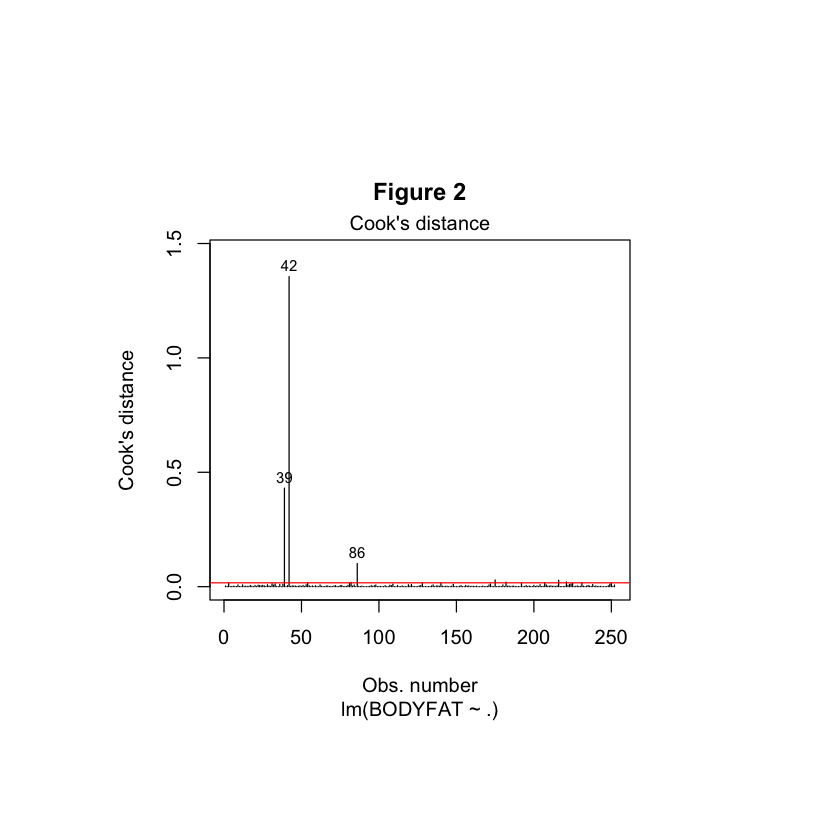

In [7]:
# Look at Cook's distance
dat <- subset(dat, select = -c(DENSITY, IDNO))
par(pin = c(3.5, 3))
plot(lm(BODYFAT ~ ., dat), which = 4, main = "Figure 2")
abline(h = 4 / (dim(dat)[1] - 14 - 1), col = "red")

In [8]:
# Look at abnomal points to see if they should be deleted
dat[c(39, 42, 86),]

BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
31.7,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
25.8,67,167.00,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


* **39**: Although weight of this male is extremely high, values of other predictors confirm this weight is true. This record is definitely not a wrong record. It's a trade-off for us to decide whether to keep such a fat person in our model. We want our method to be precise and robust, which means we want our calculator to have good performance for data drawn from a wide range of probability distributions, especially for distributions that are not normal. We will first keep this and show the reasons later.
* **42**: The $HEIGHT$ is 29.50 inches, which is almost certainly an erroneous record. But all the other measurements are normal. So we try to using bmi formula to see if we can recover his height. The formula is $BMI = 703 * Weight(lbs) / Height^2(in^2)$. Applying this formula results in height for this male is approximately 69.43 inches. 
* **86**: All the measurements seem reasonable, so we leave it in the dataset.

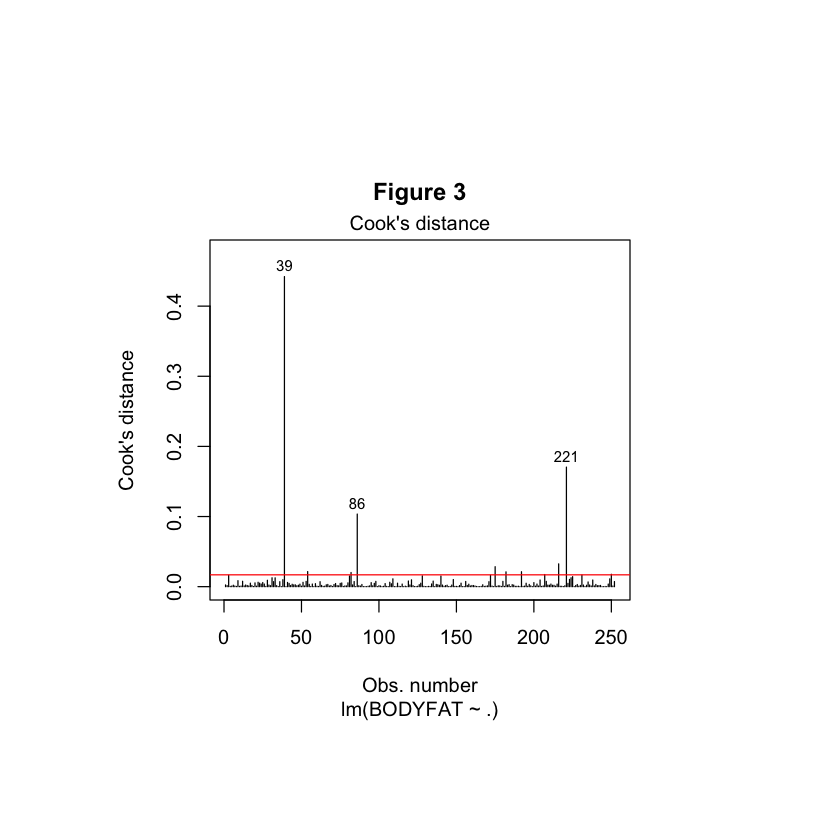

In [9]:
# Replace observation 42's height with 69.43 inches
dat$HEIGHT[42] <- 69.43
par(pin = c(3.5, 3))
plot(lm(BODYFAT ~ ., dat), which = 4, main = "Figure 3")
abline(h = 4 / (dim(dat)[1] - 14 - 1), col = "red")

Although there are still some abnormal points, we do not have enough reason to delete them from the dataset.So we just keep them and then do analysis. And for the 79th point which we found it strange at the glance of data, we still want to keep it. Although someone may argue that old people may not care about bodyfat, we still want our calculator to provide bodyfat reference number of all kinds of people in case they need. 

# Concerns With Linear Regression Model

We choose to use simple linear regression model as our final model. There are several important assumptions about linear regression:

1. **Linear relationship**: We will check linear relationship between $BODYFAT$ and each covariate after outlier detection. 

2. **Multivariate normality**: We will use Q-Q plot to check this assumption.

3. **Homoscedasticity**: We will use diagnostic plot to check this assumption

4. **Error term independence**: We will use diagnostic plots to check this assumption.

5. **Multicollinearity**: We use Variance Inflation Factor to check multicollinearity. Since our goal is prediction, we do not need to worry too much about this.

6. **Sensitive to outliers**: During data cleaning, we draw a linear relationship diagnostic plot to detect outliers.

7. **Additive model**: It is additive in the predictors and error term, not multiplicative

8. **Constant coefficients**: The unknown parameters  β0  and  β1  are constant (i.e. do not change with  X ).

9. **Fixed effect model**: The predictors X are assumed to be fixed.


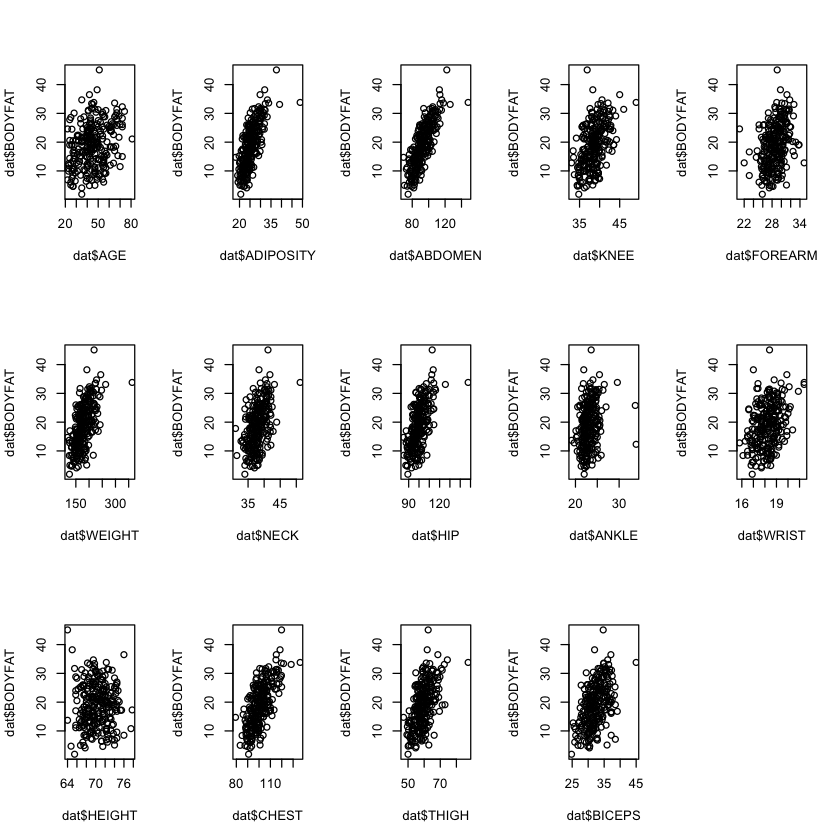

In [10]:
layout(matrix(seq(1,15),nrow=3))
plot(dat$AGE, dat$BODYFAT)
plot(dat$WEIGHT, dat$BODYFAT)
plot(dat$HEIGHT, dat$BODYFAT)
plot(dat$ADIPOSITY, dat$BODYFAT)
plot(dat$NECK, dat$BODYFAT)
plot(dat$CHEST, dat$BODYFAT)
plot(dat$ABDOMEN, dat$BODYFAT)
plot(dat$HIP, dat$BODYFAT)
plot(dat$THIGH, dat$BODYFAT)
plot(dat$KNEE, dat$BODYFAT)
plot(dat$ANKLE, dat$BODYFAT)
plot(dat$BICEPS, dat$BODYFAT)
plot(dat$FOREARM, dat$BODYFAT)
plot(dat$WRIST, dat$BODYFAT)
layout(1)

By checking the above scatterplots between $BODYFAT$ and each covariate, we conclude that the linear relationship assumption is satisfied.

# Variable Selection

To keep our model simple, we want to select at most four features for our final estimator. In order to identify the most predictive features, we use two methods:

* Stepwise variable selection based on AIC and BIC criteria

* LASSO regression

After identifying the most useful variables, we use best subset selection to find the best features for a model containing $p=1,2,3,4$ variables. Best subset selection is more computationally intensive, so it's better to use it after we've alrady narrowed our feature space to a few variables.

Besides, from all kinds of online bodyfat percentage calculators, we found weight, wrist, hip, forearm are mostly used variables. However, these calculator may based on their own data. It is not reasonable if we directly use them as selected predictors in our final model since we have our own data. But this provide us a way to doublecheck our variable selction process.

### Stepwise Selection

First, we perform stepwise variable selection to try and find a small number of important features. This is done using bidirectional steps with both AIC and BIC.

In [11]:
lm.max <- lm(BODYFAT ~ ., data = dat)
lm.min <- lm(BODYFAT ~ 1, data = dat)
scope <- list(lower=lm.min, upper=lm.max)

# AIC
lm1 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC
lm2 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC

# BIC
lm3 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))
lm4 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))

# Found models
cat("AIC stepwise starting with full model results in:")
summary(lm1)$call
cat("\n\nAIC stepwise starting with empty model results in:")
summary(lm2)$call
cat("\n\nBIC stepwise starting with full model results in:")
summary(lm3)$call
cat("\n\nBIC stepwise starting with empty model results in:")
summary(lm4)$call

AIC stepwise starting with full model results in:

lm(formula = BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + 
    THIGH + FOREARM + WRIST, data = dat)



AIC stepwise starting with empty model results in:

lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + 
    BICEPS + AGE, data = dat)



BIC stepwise starting with full model results in:

lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = dat)



BIC stepwise starting with empty model results in:

lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, data = dat)

As can be seen above, the AIC criterion tends to result in models which are too large. However, BIC results in a model containing only $ABDOMEN$, $WEIGHT$, $WRIST$, and $FOREARM$. Please notice that this result is exactly the variables used by online calculators. So we consider our method is effective to some degree. 

### LASSO Regression

Next, we use LASSO regression to find a sufficiently sparse model.

In [12]:
# Feature matrix
lasso.dat <- as.matrix(subset(dat, select = -BODYFAT))

# Cross-validated selection of lambda
cv.lasso1 <- cv.glmnet(x = lasso.dat, y = dat$BODYFAT, 
                       type.measure = 'mse', alpha = 1)

# Best lambda for each model size
lasso.results <- data.frame(p = cv.lasso1$glmnet.fit$df,
                            explained = cv.lasso1$glmnet.fit$dev.ratio,
                            lambda = cv.lasso1$glmnet.fit$lambda)
cat("Results of Lasso regression at the best Lambda value for each model size:\n")
print(lasso.results[c(18, 21, 24, 33, 34, 42, 46, 49),])

# Lasso regression using a specific lambda value chosen from above
m1 <- glmnet(lasso.dat, dat$BODYFAT, lambda = 0.31424241, alpha = 1)

# Standard error of the above model `m1`
cat("\nRoot MSE for lambda=0.314: ",
    root.mse(dat$BODYFAT, predict(m1, lasso.dat))) # = 4.132473

Results of Lasso regression at the best Lambda value for each model size:
    p explained     lambda
18  1 0.6231665 1.26860203
21  2 0.6472171 0.95965091
24  3 0.6647695 0.72594072
33  4 0.7055080 0.31424241
34  5 0.7079016 0.28632598
42  6 0.7234141 0.13602804
46  8 0.7280186 0.09375885
49 10 0.7324154 0.07092513

Root MSE for lambda=0.314:  4.149806

The above table lists the $\lambda$-value which minimizes the root mean-squared error for a model containing $p=1,...,8$ features. Choosing the LASSO regression with 4 terms results in a root MSE of 4.13. The features contained in this regression are $AGE$, $HEIGHT$, $ABDOMEN$, and $WRIST$.

### Best Subset Selection

Stepwise selection and LASSO regression identified 6 variables in total:

$ABDOMEN$, $WRIST$, $WEIGHT$, $FOREARM$, $AGE$, $HEIGHT$

We next perform best subset selection (BSS) to determine which of these variables should be included in a model with $p=1,2,3,4$ variables.

In [13]:
# Feature matrix containing WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT
dat.6vars <- as.matrix(
  subset(dat, select = c(WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT)))

# Best subset selection
best.subset <- regsubsets(x = dat.6vars, y = dat$BODYFAT, nvmax = 4,
                          method = 'exhaustive')
summary(best.subset)$outmat

,WEIGHT,ABDOMEN,FOREARM,WRIST,AGE,HEIGHT
1 ( 1 ),,*,,,,
2 ( 1 ),*,*,,,,
3 ( 1 ),*,*,,*,,
4 ( 1 ),*,*,*,*,,


The results of BSS are displayed above. We can see that the results for a 4-variable model are the same as those from our stepwise selection process using the BIC criterion.

Now, we run an OLS regression for each of these four models and assess the standard error of their fits.

In [14]:
cat("p = 1  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN, dat))$sigma,
    "\np = 2  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, dat))$sigma,
    "\np = 3  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST, dat))$sigma,
    "\np = 4  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, dat))$sigma,
    sep = "")

p = 1  -->  sigma = 4.537817
p = 2  -->  sigma = 4.144309
p = 3  -->  sigma = 4.081215
p = 4  -->  sigma = 4.041651

A 2-variable model is a solid improvement over a 1-variable model, but the improvements from adding a $3^{rd}$ or $4^{th}$ variable are small. This leads us to conclude that a 2-variable model containing $ABDOMEN$ and $WEIGHT$ is the best balance between accuracy and simplicity.

# Final Model

Our final model takes the form:

$$ \text{(Body Fat %)}_i = \beta_0 + \beta_1 \cdot \text{ABDOMEN}_{i} + \beta_2 \cdot \text{WEIGHT}_{i} + \epsilon_i, \quad{} \epsilon_i \sim N(0,\sigma^2) $$


The coefficient estimates are shown below.

In [15]:
bodyfat.model <- lm(BODYFAT ~ ABDOMEN + WEIGHT, data = dat)
round(as.data.frame(coef(bodyfat.model), 1))

,coef(bodyfat.model)
(Intercept),-40
ABDOMEN,1
WEIGHT,0


### Interpretation of SLR results
0. A note for multiple hypothesis testing: In this interpretation, we will talk about several hypothesis tests, which will require significance level to be adjusted. Roughly using Bonferroni method, we can still declare significance here. However, in order to be well-understood, we did not using the declaration of adjusted significance level here.
1. Coefficients: When weight is fixed, bodyfat will increase 0.91 percent if abdomen increase one centimeter. When abdomen is fixed, bodyfat will decrease 0.14 percent if weight increase one pound. The latter result may seem strange at first, but we can say this, abdomen is in fact a measure of obesity. But if abdomen is fixed and weight increase, the gain of weight is not because of fat but because of muscle which will result in low bodyfat. 
2. Hypothesis testing for t tests: For each coefficient $ \beta_{i} $, we have t test: $H_0: \beta_1 = 0$ vs $H_1: \beta_1 \neq 0$. The associated p-value for coefficients of abdomen and intercept are less 2*10^-16 while that of weight is 1.14*10^-11. We can declare that there is a linear relationship between abdomen weight and body fat %. However, our conclusion carries a 5% error rate where we may have falsely declared that there is a relationship even though there truly isn't a relationship.
3. Hypothesis testing for F test: Using p value from F test which is less than 2.2*10^-16, we can conclude that our model is effective with 5% error rate.
4. $ R^2 $: Abdomen and weight explain about 70.98% of the variation in body fat %.

In [16]:
round(confint(bodyfat.model), 2)

,2.5 %,97.5 %
(Intercept),-45.04,-35.50
ABDOMEN,0.80,1.01
WEIGHT,-0.18,-0.10


The 95% confidence interval for the coefficient of abdomen is  $(0.80,1.01)$, for the coefficient of weight is  $(-0.18,-0.10)$, and the intercept is $(-45.04,-35.50)$. In other words, we are 95% confident that our intervals contain the corresponding true coefficients' values.


# Rule of Thumb

We can simplify this model into the following rule of thumb:

$ BODYFAT \% = 0.91\cdot ABDOMEN(lbs) - 0.14\cdot WEIGHT(cm) - 40 \%$

This formula is not difficult to memorize and can be evaluated with a calculator in a few seconds, so we are content with its simplicity. Besides, the weight and abdomen are not difficult to measure, we regard this formula can be widely used. Moreoever, it is still precise:

In [17]:
# Exact model predictions
bodyfat.model.yhat <- predict(bodyfat.model, dat)

# Simplified rule of thumb predictions
rot.yhat <- 0.91 * dat$ABDOMEN - 0.14 * dat$WEIGHT - 40

# Exact vs. rule of thumb accuracy
cat('Standard error of exact model:   ',
    root.mse(dat$BODYFAT, bodyfat.model.yhat))
cat('\nStandard error of rule of thumb: ',
    root.mse(dat$BODYFAT, rot.yhat))

Standard error of exact model:    4.119567
Standard error of rule of thumb:  4.123639

**Example Usage** : for an ordinary man with abdomen 84cm and weight 173lbs, his predicted body fat % percentage would be around 12.05%. There is a 95% probability that his body fat is between 3.85% and 20.26%.

In [18]:
round(predict(bodyfat.model, newdata = data.frame(ABDOMEN = 84, WEIGHT = 173),
              interval = "predict"), 2)

fit,lwr,upr
12.05,3.85,20.26


# Model Evaluation and Diagnostics

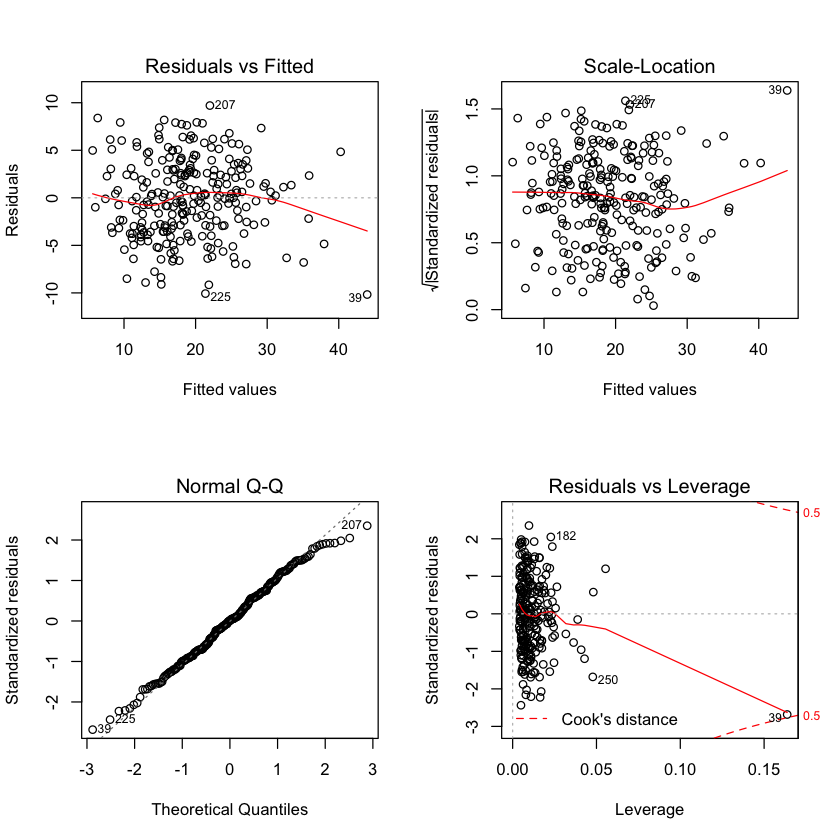

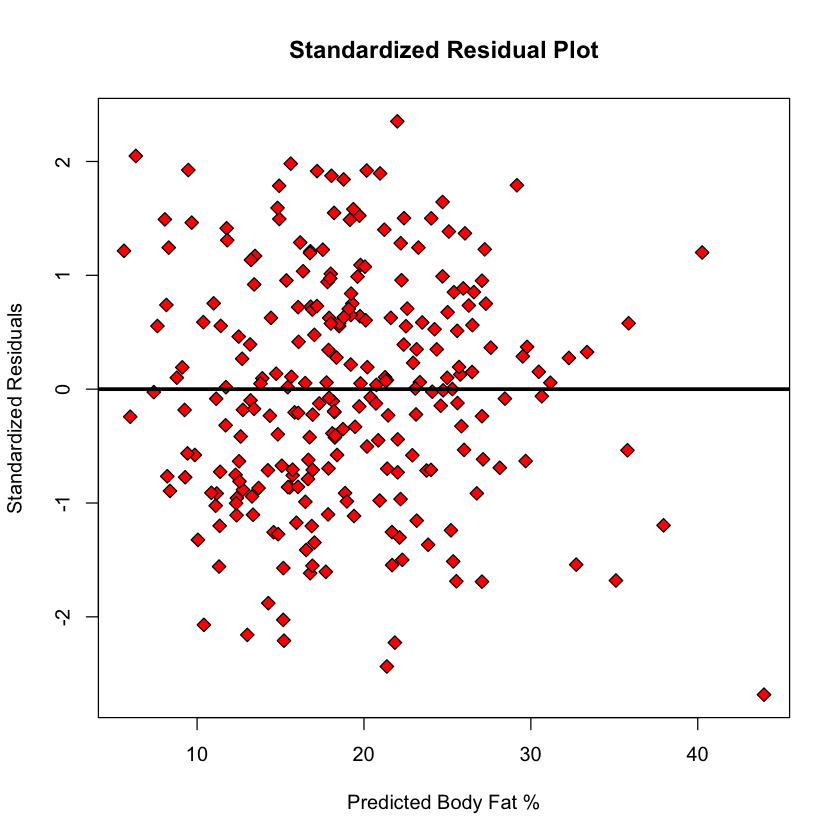

In [19]:
# Model diagnostic plots
layout(matrix(c(1, 2, 3, 4), nrow = 2))
plot(bodyfat.model)
layout(1)
plot(predict(bodyfat.model), rstandard(bodyfat.model), pch = 23, bg = "red",
     cex = 1.2, xlab = "Predicted Body Fat %", ylab = "Standardized Residuals",
     main = "Standardized Residual Plot")
abline(a = 0, b = 0, col = "black", lwd = 3)

VIF values for assessing multicollinearity:


ABDOMEN   WEIGHT 
4.728915 4.728915

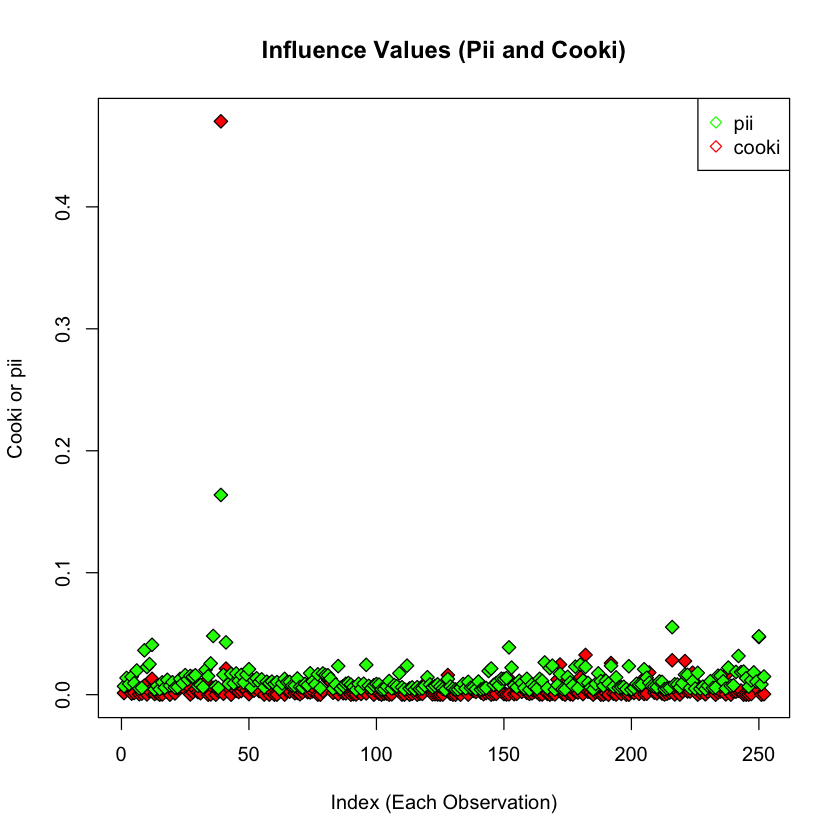

In [20]:
# Multicolinearity
cat("VIF values for assessing multicollinearity:\n")
vif(bodyfat.model)

# Outlier or influential points 
pii = hatvalues(bodyfat.model)
cooki = cooks.distance(bodyfat.model)
n = dim(dat)[1]
plot(1:n, cooki, type = "p", pch = 23, bg = "red", cex=1.2,
     xlab = "Index (Each Observation)", ylab = "Cooki or pii",
     main = "Influence Values (Pii and Cooki)")
points(1:n, pii, type = "p", pch = 23, bg = "green", cex = 1.2)
legend("topright", legend = c("pii", "cooki"), pch = c(23,23),
       col = c("green", "red"))

From diagnostic plots, we conclude:

1. Linearity: from the plot of fitted values versus residuals, we can confirm that the linear assumption is satisfied
2. Additivity: seems reasonable from the interpretation of coefficients
3. Constant effects: have no reason to deny.
4. Fixed X: have no reason to deny.
5. Normally distributed errors: seems reasonable from the QQ plot.
6. Constant variance: the error terms are independent and have equal variance. 
7. Multicolinearity: from vif value, we found there still exist multicolinearity between abdomen and weight, and this is reasonable in practice. However, because our aim is to do prediction, we want to keep this problem as our weekness.
7. Outliers: we first look at cook's distance and pii values. Figure shows that 39th point need our attention. Please notice that the leverage plot shows that the 39th point is an outlier. In order to determine whether or not this point should be removed, we decided to evaluate the trade-off between robustness and precision in our model when the point is removed and kept.

We fit our final model with and without 39th point to see how much the coefficients changed:

,coef(bodyfat.model)
(Intercept),-40.27
ABDOMEN,0.91
WEIGHT,-0.14


,coef(without)
(Intercept),-41.77
rodata$ABDOMEN,0.90
rodata$WEIGHT,-0.12


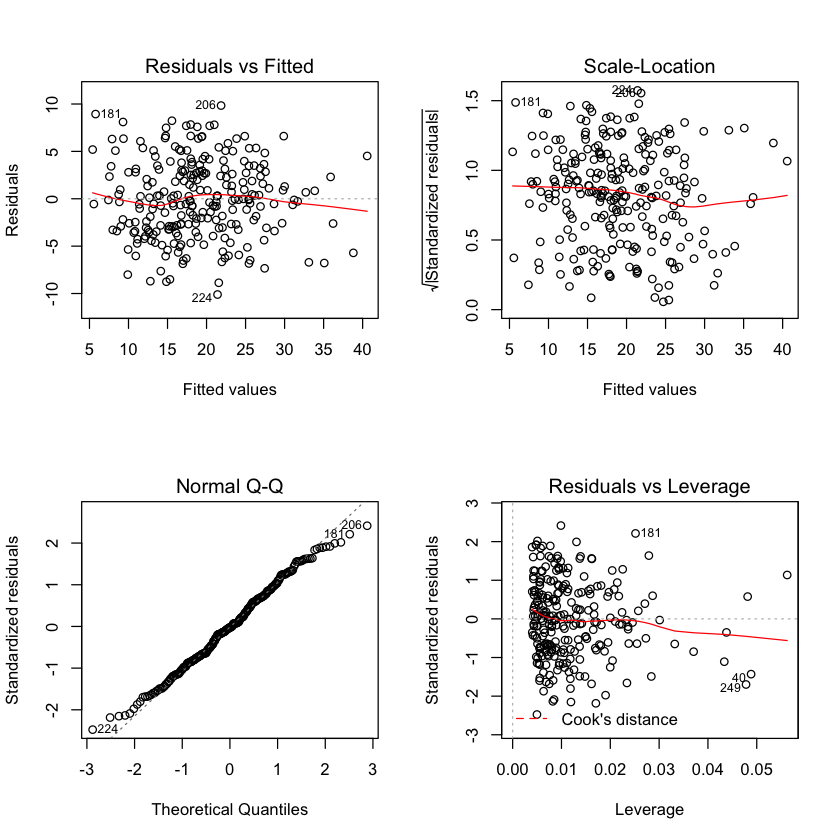

In [21]:
# The 39th point is an outlier, so we decided to evaluate our model's robustness
rodata <- dat[-39,]
without <- lm(rodata$BODYFAT ~ rodata$ABDOMEN + rodata$WEIGHT)
round(as.data.frame(coef(bodyfat.model)), 2)
round(as.data.frame(coef(without)), 2)
layout(matrix(c(1, 2, 3, 4), nrow = 2))
plot(without)

This shows a trade-off between robustness and precison. Removing the 39th point does make our final model more accurate and this can be measured from the residual standard error (which is about 0.056 better when the point is removed).

However, we want our model to be robust; that is, we want it to be useful for a wide range of individuals. The inclusion or exclusion of the 39th point does not seem to affect the coefficients much, which indicates that our model is relatively robust to outliers. Since point 39 does not appear to be an error, we will keep it in the dataset and regard this as our final model.

# Conclusion

Our final rule of thumb is:

$ BODYFAT = 0.91\cdot ABDOMEN - 0.14\cdot WEIGHT - 40$

which can be described as "90% abdomen minus 10% weight, don't forget to minus 40%, get your body fat!"

This estimator is easy to understand and can be quickly computed since it only uses two variables. It is robust to outlier individuals and provides relatively precise estimates of body fat percentage.

# Strengths and Weakness of Analysis 
**Strengths:**
We believe we provide a simple, robust, accurate and precise  “rule-of-thumb” method.
1. We evaluate robustness and precision to prove efficiency of our model.
2. We use background information to impute strange points because we don't want to lose more data points.

**Weakness:**
1. There is p hacking problem in our analysis.
2. We did not solve multicolinearity problem in our final model, maybe ridge regression instead of SLR does better.
3. The negative coefficient on $WEIGHT$ constrains the range of feasible weight values somewhat. If weight is very low yet the abdomen measurement is not, the estimator may overestimate the body fat percentage.

Nonetheless, we still believe that the advantages of having a simple and easy-to-use rule of thumb outweight these disadvantages.

# Contribution

1. The whole idea is contributed by all of us
2. R code is completed more by YUNHUI QI and Sam Waterbury, JUNXIA ZHU also contributed.
3. Jupyter notebook is completed by all of us
4. Shiny app is mostly completed by YUNHUI QI, but Sam and JUNXIA provided many useful suggesstions
5. Slides are completed by all of us.

# Reference
https://bmi-calories.com/body-fat-percentage-calculator.html